In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from datasets import Dataset
import tensorflow as tf
import warnings


from transformers import AutoTokenizer
from datasets import Dataset, DatasetDict
from torch.utils.data import DataLoader
from transformers import AutoModelForMaskedLM
from torch import nn
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW
from transformers import get_scheduler
import evaluate
from tqdm.auto import tqdm
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, 
                             confusion_matrix, classification_report)
import matplotlib.pyplot as plt
import seaborn as sns


# Ignore Warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/Users/thiri/Downloads/bt4222/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Check cuda status
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


### Prepare dataset

In [3]:
# Webscraped twitter data
df = pd.read_csv('source data/users.csv')
df_main = pd.read_csv("cleaned data/cleaned_data_split.csv",index_col=0)
df_main['Handle'] = '@' + df_main['screen_name']

# Merge df and df_main
result = df.merge(df_main, on='Handle', how='inner')

# replace NaN values in 'Content' and 'description' with 'NA'
result_final = result.fillna({'Content': 'NA', 'description': 'NA'})

In [4]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Convert pandas DataFrame to Hugging Face dataset format
result_final = result_final[['Content', 'account_type']].reset_index(drop=True)
dataset = Dataset.from_pandas(result_final)

# Perform an 80-20 train-test split with a fixed random seed
train_test_split = dataset.train_test_split(test_size=0.2, seed=42)

In [5]:
# Check max content length for padding
content_length = result_final['Content'].apply(lambda x: len(str(x).split()))
max_content_len = max(content_length)

print("Max length of content is: ", max_content_len)

Max length of content is:  64


### Tokenization

In [6]:
# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples["Content"], padding="max_length", truncation=True, max_length=max_content_len)

# Tokenize the training and testing datasets
tokenized_train = train_test_split['train'].map(tokenize_function, batched=True)
tokenized_test = train_test_split['test'].map(tokenize_function, batched=True)

# Rename column 'account_type' to 'labels'
tokenized_train = tokenized_train.rename_column("account_type", "labels")
tokenized_test = tokenized_test.rename_column("account_type", "labels")

# Remove the 'Content' column from the tokenized datasets
tokenized_train = tokenized_train.remove_columns(["Content"])
tokenized_test = tokenized_test.remove_columns(["Content"])

# Set format for PyTorch
tokenized_train.set_format("torch", columns=["labels", "input_ids", "token_type_ids", "attention_mask"])
tokenized_test.set_format("torch", columns=["labels", "input_ids", "token_type_ids", "attention_mask"])

# Create a DatasetDict
tokenized_datasets = DatasetDict({
    "train": tokenized_train,
    "test": tokenized_test
})

# Check the structure of the DatasetDict
print(tokenized_datasets)

Map: 100%|██████████| 575/575 [00:00<00:00, 31407.17 examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2298
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 575
    })
})


In [7]:
train_dataset = tokenized_datasets["train"].shuffle(seed=42)
eval_dataset = tokenized_datasets["test"].shuffle(seed=42)

### Create DataLoader

In [8]:
from torch.utils.data import DataLoader

batchsize=10
# Create Dataloader
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batchsize)
eval_dataloader = DataLoader(eval_dataset, batch_size=batchsize)

## Model Structure

### Define Model Architecture

In [9]:
from transformers import AutoModelForMaskedLM
import torch
from torch import nn

class Model(nn.Module):
    def __init__(self,output_dim,dropout_rate):
        super(Model,self).__init__()
        self.encoder=AutoModelForMaskedLM.from_pretrained("bert-base-uncased", output_hidden_states=True, return_dict=True)
        self.dropout=nn.Dropout(dropout_rate)
        self.classifier=nn.Linear(3072,output_dim)

    def forward(self,input_ids,token_type_ids,attention_mask):
        outputs = self.encoder(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)
        hidden_states = torch.cat(tuple([outputs.hidden_states[i] for i in [-1, -2, -3, -4]]), dim=-1)

        x=self.dropout(hidden_states[:, 0, :])
        x=self.classifier(x)
        return x

### Create Model Instance

In [10]:
model = Model(output_dim=2, dropout_rate = 0.5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
loss_fct = CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=5e-5)

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
/Users/thiri/Downloads/bt4222/.venv/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT s

### Training and Evaluation

In [11]:
epochs = 5
num_training_steps = epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
    )
metric = evaluate.load("accuracy")
progress_bar = tqdm(range(num_training_steps))

  0%|          | 0/1150 [00:00<?, ?it/s]

In [12]:
from sklearn.metrics import classification_report

all_true_labels = []
all_predictions = []

for epoch in range(epochs):
        for batch in train_dataloader:
            model.train()
            # Loop through batches in the training data loader
            batch = {k: v.to(device) for k, v in batch.items()}
            label_ids = batch['labels'].long()
            input_ids = batch['input_ids']
            token_type_ids = None
            attention_mask = batch['attention_mask']
            # Forward pass
            logits = model(input_ids, token_type_ids, attention_mask)
            
            # Calculate loss
            loss = loss_fct(logits, label_ids.view(-1))
            # Perform backward pass and update model parameters
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            progress_bar.update(1)

        model.eval()
        true_labels = []
        predictions = []

        for batch in eval_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.no_grad():
                label_ids = batch['labels'].long()
                input_ids = batch['input_ids']
                token_type_ids = None
                attention_mask = batch['attention_mask']
                logits = model(input_ids, token_type_ids, attention_mask)
                loss = loss_fct(logits, label_ids.view(-1))

            # Get predicted labels by selecting the class with the highest probability
            preds = torch.argmax(logits, dim=-1)
            
            metric.add_batch(predictions=preds, references=batch["labels"])

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(label_ids.cpu().numpy())
        
        all_true_labels.extend(true_labels)
        all_predictions.extend(predictions)

        acc = metric.compute()
        print(f'Epoch {epoch+1}')
        print(f'val_loss : {loss}')
        print(25*'==')

 20%|██        | 230/1150 [04:02<17:11,  1.12s/it]

Epoch 1
val_loss : 0.8100759387016296


 40%|████      | 460/1150 [08:44<13:35,  1.18s/it]  

Epoch 2
val_loss : 0.7833863496780396


 60%|██████    | 690/1150 [13:56<08:13,  1.07s/it]  

Epoch 3
val_loss : 1.0808978080749512


 80%|████████  | 920/1150 [18:41<04:17,  1.12s/it]

Epoch 4
val_loss : 1.2178082466125488


100%|██████████| 1150/1150 [23:26<00:00,  1.11s/it]

Epoch 5
val_loss : 1.3804311752319336


### Performance Metrics

In [13]:
report = classification_report(all_true_labels, all_predictions, target_names=["Not Bot", "Bot"], labels=[0,1])
print("Final Classification Report:\n", report)

Final Classification Report:
               precision    recall  f1-score   support

     Not Bot       0.83      0.93      0.88      2185
         Bot       0.63      0.40      0.49       690

    accuracy                           0.80      2875
   macro avg       0.73      0.66      0.68      2875
weighted avg       0.78      0.80      0.78      2875



In [14]:
recall = recall_score(all_true_labels, all_predictions)
precision = precision_score(all_true_labels, all_predictions)
f1 = f1_score(all_true_labels, all_predictions)

print("Recall: ", recall)
print("Precision: ", precision)
print("F1-Score:", f1)

Recall:  0.39565217391304347
Precision:  0.6290322580645161
F1-Score: 0.48576512455516013


### Confusion Matrix

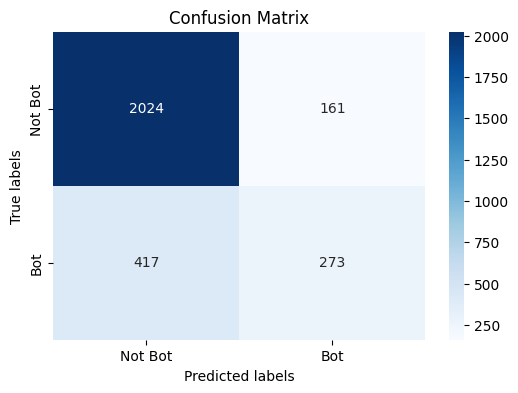

In [15]:
cm = confusion_matrix(all_true_labels, all_predictions)
labels = ["Not Bot", "Bot"]

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [17]:
# Save model
torch.save(model, "output_files/content_sentiment_analysis.pkl")